In [111]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GroupKFold
from sklearn.feature_selection import SelectFromModel

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.base import clone
from IPython.display import clear_output
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
data = pd.read_csv('SI670_Final Project Data.csv')
data

,FAC_NO,FAC_NAME,BEG_DATE,END_DATE,DAY_PER,DATA_IND,AUDIT_IND,COUNTY,HSA,HFPA,...,MCAR_PRO#,MCAL_PRO#,REG_MCAL#,BED_LIC,BED_AVL,BED_STF,Variable,Amount,WEB-SITE,ORG-NAME
0,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_ MCAR_TR,12330.0,NaN,NaN
1,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_MCAR_MC,885.0,NaN,NaN
2,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_MCAL_TR,13093.0,NaN,NaN
3,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_ MCAL_ MC,1786.0,NaN,NaN
4,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_CNTY,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578345,106580996,RIDEOUT MEMORIAL HOSPITAL,01JUL2016,30JUN2017,365,In Process,Incl. Ind. Audit Adj.,Yuba,2,227,...,05-0133,172008835,ZZR00133F,221,219,152,PD_HR_ED,0.0,NaN,NaN
578346,106580996,RIDEOUT MEMORIAL HOSPITAL,01JUL2016,30JUN2017,365,In Process,Incl. Ind. Audit Adj.,Yuba,2,227,...,05-0133,172008835,ZZR00133F,221,219,152,PD_HR_GEN,475235.0,NaN,NaN
578347,106580996,RIDEOUT MEMORIAL HOSPITAL,01JUL2016,30JUN2017,365,In Process,Incl. Ind. Audit Adj.,Yuba,2,227,...,05-0133,172008835,ZZR00133F,221,219,152,PD_HR_FIS,186036.0,NaN,NaN
578348,106580996,RIDEOUT MEMORIAL HOSPITAL,01JUL2016,30JUN2017,365,In Process,Incl. Ind. Audit Adj.,Yuba,2,227,...,05-0133,172008835,ZZR00133F,221,219,152,PD_HR_ADM,367425.0,NaN,NaN


# Data Preprocessing

In [31]:
warnings.filterwarnings("ignore")

data['BEG_DATE'] = pd.to_datetime(data['BEG_DATE'], errors='coerce')
data['END_DATE'] = pd.to_datetime(data['END_DATE'], errors='coerce')

In [32]:
data['BED_LIC'] = pd.to_numeric(data['BED_LIC'], errors='coerce').fillna(0).astype(float)
data['BED_AVL'] = pd.to_numeric(data['BED_AVL'], errors='coerce').fillna(0).astype(float)
data['BED_STF'] = pd.to_numeric(data['BED_STF'], errors='coerce').fillna(0).astype(float)

In [33]:
data['Bed_Utilization'] = data['BED_AVL'] / (data['BED_LIC'] + 1e-9)
data['BEG_MONTH'] = pd.to_datetime(data['BEG_DATE']).dt.month

data['BEG_MONTH_sin'] = np.sin(2 * np.pi * data['BEG_MONTH'] / 12)
data['BEG_MONTH_cos'] = np.cos(2 * np.pi * data['BEG_MONTH'] / 12)

In [34]:
data['TYPE_CARE'] = data['TYPE_CARE'].apply(lambda x: 'Children' if x in ['Childrens', "Children's"] else x)
data['TYPE_CARE'] = data['TYPE_CARE'].apply(lambda x: 'General' if x in ['General Acu'] else x)

In [35]:
FAC_NO_to_NAME_mapping = dict(zip(data['FAC_NO'], data['FAC_NAME']))

county_mapping = {county: idx for idx, county in enumerate(data['COUNTY'].unique())}
data['COUNTY'] = data['COUNTY'].map(county_mapping)

city_mapping = {city: idx for idx, city in enumerate(data['CITY'].unique())}
data['CITY'] = data['CITY'].map(city_mapping)

audit_mapping = {audit: idx for idx, audit in enumerate(data['AUDIT_IND'].unique())}
data['AUDIT_IND'] = data['AUDIT_IND'].map(audit_mapping)

In [36]:
data.loc[data['Variable'] == 'INTER-REC', 'Variable'] = 'INTER_REC'
data.loc[data['Variable'] == 'NAT-BIRTHS', 'Variable'] = 'NAT_BIRTHS'
data.loc[data['Variable'] == 'ALLOW-UNCOL', 'Variable'] = 'ALLOW_UNCOL'
data.loc[data['Variable'] == 'ALLOW_UNCOLL', 'Variable'] = 'ALLOW_UNCOL'
data.loc[data['Variable'] == 'DAYS_PIPS', 'Variable'] = 'DAY_PIPS'
data.loc[data['Variable'] == 'ACCTC_REC', 'Variable'] = 'ACCTS_REC'
data.loc[data['Variable'] == 'CURR_LIAB', 'Variable'] = 'CUR_LIAB'

data['Variable'] = data['Variable'].str.replace(" ", "", regex=False)

In [37]:
data.drop(columns = ['WEB_SITE', 'ORG_NAME', 'ER_DESIG', 'MCAR_PRO#', 'MCAL_PRO#', 'REG_MCAL#', 'WEB-SITE', 'ORG-NAME', 'FAC_NAME', 'DATA_IND', 
                     'PHONE', 'ADDRESS', 'CEO', 'CEO_TITLE', 'RPT_PREP', 'ORG_NAME', 'HFPA', 'HSA', 
                     'TEACH_RURL', 'OWNER', 'ZIP_CODE', 'BEG_DATE', 'END_DATE'
                     ], inplace=True)

data.dropna(subset='COUNTY', inplace=True)
data

,FAC_NO,DAY_PER,AUDIT_IND,COUNTY,TYPE_CNTRL,TYPE_CARE,TYPE_HOSP,CITY,BED_LIC,BED_AVL,BED_STF,Variable,Amount,Bed_Utilization,BEG_MONTH,BEG_MONTH_sin,BEG_MONTH_cos
0,106010735,366,0,0,District,General,Comparable,0,161.0,161.0,161.0,DAY_MCAR_TR,12330.0,1.00000,7,-0.5,-0.866025
1,106010735,366,0,0,District,General,Comparable,0,161.0,161.0,161.0,DAY_MCAR_MC,885.0,1.00000,7,-0.5,-0.866025
2,106010735,366,0,0,District,General,Comparable,0,161.0,161.0,161.0,DAY_MCAL_TR,13093.0,1.00000,7,-0.5,-0.866025
3,106010735,366,0,0,District,General,Comparable,0,161.0,161.0,161.0,DAY_MCAL_MC,1786.0,1.00000,7,-0.5,-0.866025
4,106010735,366,0,0,District,General,Comparable,0,161.0,161.0,161.0,DAY_CNTY,0.0,1.00000,7,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578345,106580996,365,0,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ED,0.0,0.99095,7,-0.5,-0.866025
578346,106580996,365,0,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_GEN,475235.0,0.99095,7,-0.5,-0.866025
578347,106580996,365,0,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_FIS,186036.0,0.99095,7,-0.5,-0.866025
578348,106580996,365,0,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ADM,367425.0,0.99095,7,-0.5,-0.866025


In [38]:
data.isna().sum()

FAC_NO             0
DAY_PER            0
AUDIT_IND          0
COUNTY             0
TYPE_CNTRL         0
TYPE_CARE          0
TYPE_HOSP          0
CITY               0
BED_LIC            0
BED_AVL            0
BED_STF            0
Variable           0
Amount             0
Bed_Utilization    0
BEG_MONTH          0
BEG_MONTH_sin      0
BEG_MONTH_cos      0
dtype: int64

# Training - Testing Data split
### 95 FAC_NOs for testing

In [39]:
unique_facilities = data['FAC_NO'].unique()
num_total = len(unique_facilities)
num_train = int(0.8 * num_total)

train_facilities = set(unique_facilities[:num_train])
test_facilities = set(unique_facilities[num_train:])

data_train = data[data['FAC_NO'].isin(train_facilities)]
data_test = data[data['FAC_NO'].isin(test_facilities)]

In [40]:
print('Train Data:',data_train.FAC_NO.nunique())
print('Test Data:',data_test.FAC_NO.nunique())

Train Data: 377
Test Data: 95


# Grouping Variables

In [41]:
grouped_columns = {

    "Inpatient Utilization by Payer": [
        "DAY_MCAR_TR", "DAY_MCAR_MC", "DAY_MCAL_TR", "DAY_MCAL_MC", "DAY_CNTY",
        "DAY_THRD_TR", "DAY_THRD_MC", "DAY_OTH_IND", "DAY_OTH", "DAY_TOT",
        "DIS_MCAR_TR", "DIS_MCAR_MC", "DIS_MCAL_TR", "DIS_MCAL_MC", "DIS_CNTY",
        "DIS_THRD_TR", "DIS_THRD_MC", "DIS_OTH_IND", "DIS_OTH", "DIS_TOT"
    ],
    "Licensed Beds and Utilization by Type of Care": [
        "BED_ACUTE", "BED_PSYCH", "BED_CHEM", "BED_REHAB", "BED_LTC", "BED_RESDNT",
        "DAY_ACUTE", "DAY_PSYCH", "DAY_CHEM", "DAY_REHAB", "DAY_LTC", "DAY_RESDNT",
        "DIS_ACUTE", "DIS_PSYCH", "DIS_CHEM", "DIS_REHAB", "DIS_LTC", "DIS_RESDNT",
        "OCC_LIC", "OCC_AVL", "ALOS_ALL", "ALOS_EXLTC"
    ],
    "Nursery Information": ["BAS_NURSRY", "DAY_NURSRY", "DIS_NURSRY"],
    "Outpatient Visits by Payer": [
        "VIS_MCAR_TR", "VIS_MCAR_MC", "VIS_MCAL_TR", "VIS_MCAL_MC", "VIS_CNTY",
        "VIS_THRD_TR", "VIS_THRD_MC", "VIS_OTH_IND", "VIS_OTH", "VIS_TOT"
    ],
    "Ambulatory and Referred Outpatient Visits": ["VIS_ER", "VIS_CLIN", "VIS_HOME", "VIS_REF_OP"],
    "Managed Care Contract Utilization": ["DAY_PIPS"],
    "Other Selected Utilization Information": [
        "OP_ROOM", "OP_MIN_IP", "OP_MIN_OP", "SURG_IP", "SURG_OP", "NAT_BIRTHS", "C_SECTIONS"
    ],
    "Summary Income Statement": [
        "GR_PT_REV", "DED_FR_REV", "TOT_CAP_REV", "NET_PT_REV", "OTH_OP_REV",
        "TOT_OP_EXP", "NET_FRM_OP", "NONOP_REV", "NONOP_EXP", "INC_TAX", "EXT_ITEM", "NET_INCOME"
    ],
    "Patient Revenue Information": [
        "GR_REV_DLY", "GR_REV_AMB", "GR_REV_ANC", "GR_IP_MCAR_TR", "GR_IP_MCAR_MC", 
        "GR_IP_MCAL_TR", "GR_IP_MCAL_MC", "GR_IP_CNTY", "GR_IP_THRD_TR", "GR_IP_THRD_MC",
        "GR_IP_OTH_IND", "GR_IP_OTH", "GR_IP_TOT", "GR_OP_MCAR_TR", "GR_OP_MCAR_MC",
        "GR_OP_MCAL_TR", "GR_OP_MCAL_MC", "GR_OP_CNTY", "GR_OP_THRD_TR", "GR_OP_THRD_MC",
        "GR_OP_OTH_IND", "GR_OP_OTH", "GR_OP_TOT"
    ],
    "Deductions from Revenue": [
        "C_ADJ_MCAR_TR", "C_ADJ_MCAR_MC", "C_ADJ_MCAL_TR", "C_ADJ_MCAL_MC", "DISP_855",
        "C_ADJ_CNTY", "C_ADJ_THRD_TR", "C_ADJ_THRD_MC", "BAD_DEBT", "CHAR_HB", "CHAR_OTH",
        "SUB_INDGNT", "DED_OTH"
    ],
    "Capitation Premium Revenue": ["CAP_REV_MCAR", "CAP_REV_MCAL", "CAP_REV_CNTY", "CAP_REV_THRD"],
    "Net Patient Revenue by Payer": [
        "NETRV_MCAR_TR", "NETRV_MCAR_MC", "NETRV_MCAL_TR", "NETRV_MCAL_MC", "NETRV_CNTY",
        "NETRV_THRD_TR", "NETRV_THRD_MC", "NETRV_OTH_IND", "NETRV_OTH"
    ],
    "Selected Financial Items": ["DISP_TRNFR", "INTER_TFR", "CONTRIBTNS", "INC_INVEST", "DIST_REV", "CNTY_APPRO"],
    "Direct Expenses by Cost Center Group": [
        "EXP_DLY", "EXP_AMB", "EXP_ANC", "EXP_PIP", "EXP_POP", "EXP_RES", "EXP_ED", "EXP_GEN",
        "EXP_FISC", "EXP_ADM", "EXP_UNASSG"
    ],
    "Expenses by Natural Classification": [
        "EXP_SAL", "EXP_BEN", "EXP_PHYS", "EXP_OTHPRO", "EXP_SUPP", "EXP_PURCH", "EXP_DEPRE",
        "EXP_LEASES", "EXP_INSUR", "EXP_INTRST", "EXP_OTH"
    ],
    "Balance Sheet Information": [
        "CUR_ASST", "ASST_LIMTD", "NET_PPE", "CONST_PROG", "INV_OTH", "INTAN_ASST", "TOT_ASST",
        "CUR_LIAB", "DEF_CRED", "NET_LTDEBT", "EQUITY", "LIAB_EQ", "CASH", "ACCTS_REC",
        "ALLOW_UNCOL", "BLDGS", "EQUIPMENT", "TOT_PPE", "ACC_DEPRE", "MORT_PAY",
        "CAP_LEASE", "BOND_PAY", "TOT_LTDEBT", "CUR_MAT", "INTER_REC", "INTER_PAY"
    ],
    "Hospital Personnel Information": [
        "HOSP_FTE", "NURS_FTE", "PROD_HRS", "NON_PRD_HR", "PAID_HRS", "MED_STAFF", "STDNT_FTE"
    ],
    "Productive Hours by Employee Classification": [
        "PRD_HR_MGT", "PRD_HR_TCH", "PRD_HR_RN", "PRD_HR_LVN", "PRD_HR_AID", "PRD_HR_CLR",
        "PRD_HR_ENV", "PRD_HR_OTH"
    ],
    "Contracted Labor Hours by Classification": ["CNT_HR_RN", "CNT_HR_OTH"],
    "Total Productive Hours by Cost Center Group": [
        "PRD_HR_DLY", "PRD_HR_AMB", "PRD_HR_ANC", "PRD_HR_ED", "PRD_HR_GEN", "PRD_HR_FIS",
        "PRD_HR_ADM", "PRD_HR_NON"
    ],
    "Total Paid Hours by Cost Center Group": [
        "PD_HR_DLY", "PD_HR_AMB", "PD_HR_ANC", "PD_HR_ED", "PD_HR_GEN", "PD_HR_FIS",
        "PD_HR_ADM", "PD_HR_NON"
    ]
}

In [42]:
len(grouped_columns.keys())

21

In [43]:
reverse_lookup = {}
for group_name, columns in grouped_columns.items():
    for column in columns:
        reverse_lookup[column] = group_name

In [44]:
reverse_lookup

{'DAY_MCAR_TR': 'Inpatient Utilization by Payer',
 'DAY_MCAR_MC': 'Inpatient Utilization by Payer',
 'DAY_MCAL_TR': 'Inpatient Utilization by Payer',
 'DAY_MCAL_MC': 'Inpatient Utilization by Payer',
 'DAY_CNTY': 'Inpatient Utilization by Payer',
 'DAY_THRD_TR': 'Inpatient Utilization by Payer',
 'DAY_THRD_MC': 'Inpatient Utilization by Payer',
 'DAY_OTH_IND': 'Inpatient Utilization by Payer',
 'DAY_OTH': 'Inpatient Utilization by Payer',
 'DAY_TOT': 'Inpatient Utilization by Payer',
 'DIS_MCAR_TR': 'Inpatient Utilization by Payer',
 'DIS_MCAR_MC': 'Inpatient Utilization by Payer',
 'DIS_MCAL_TR': 'Inpatient Utilization by Payer',
 'DIS_MCAL_MC': 'Inpatient Utilization by Payer',
 'DIS_CNTY': 'Inpatient Utilization by Payer',
 'DIS_THRD_TR': 'Inpatient Utilization by Payer',
 'DIS_THRD_MC': 'Inpatient Utilization by Payer',
 'DIS_OTH_IND': 'Inpatient Utilization by Payer',
 'DIS_OTH': 'Inpatient Utilization by Payer',
 'DIS_TOT': 'Inpatient Utilization by Payer',
 'BED_ACUTE': 'License

# Baseline LogisticRegression

In [160]:
warnings.filterwarnings("ignore")

evaluation_results_list = []
data_test_predictions_LR = data_test.copy()

cv_strategy = GroupKFold(n_splits=5)
categorical_features = ['TYPE_CNTRL', 'TYPE_CARE', 'TYPE_HOSP']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0))
])
scaler = MinMaxScaler()

for variable in data_train.Variable.unique():

    clear_output(wait=True)
    print('Processing Variable:', variable)
    print('Current column index:', list(data_train.Variable.unique()).index(variable)+1)

    current_data = data_train[data_train.Variable == variable].copy()
    current_data.drop(columns=['FAC_NO', 'Variable'], inplace=True)

    X = current_data.drop(columns=['AUDIT_IND'])
    y = current_data['AUDIT_IND']

    fold_roc_auc = []
    fold_log_loss = []

    for train_idx, test_idx in cv_strategy.split(X, y, groups=current_data.index):
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clf = clone(pipeline)
        clf.fit(X_train, y_train)
        
        y_pred_proba = clf.predict_proba(X_test)

        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        logloss = log_loss(y_test, y_pred_proba)

        fold_roc_auc.append(roc_auc)
        fold_log_loss.append(logloss)

    evaluation_results_list.append({
        'Variable': variable,
        'ROC AUC (Mean)': np.mean(fold_roc_auc),
        'ROC AUC (Std)': np.std(fold_roc_auc),
        'Log Loss (Mean)': np.mean(fold_log_loss),
        'Log Loss (Std)': np.std(fold_log_loss),
    })

    current_test_data = data_test[data_test.Variable == variable].copy()
    test_X = current_test_data.drop(columns=['FAC_NO', 'Variable', 'AUDIT_IND'])

    scaler.fit(y_pred_proba[:, 1].reshape(-1, 1))
    test_predictions = clf.predict_proba(test_X)[:, 1]
    test_predictions_normalized = scaler.transform(test_predictions.reshape(-1, 1)).flatten()

    data_test_predictions_LR.loc[current_test_data.index, 'AUDIT_IND'] = test_predictions_normalized

evaluation_results_LR = pd.DataFrame(evaluation_results_list)

Processing Variable: PD_HR_NON
Current column index: 215


In [162]:
evaluation_results_LR

,Variable,ROC AUC (Mean),ROC AUC (Std),Log Loss (Mean),Log Loss (Std)
0,DAY_MCAR_TR,0.704729,0.049286,0.619252,0.040776
1,DAY_MCAR_MC,0.701085,0.053628,0.601376,0.040072
2,DAY_MCAL_TR,0.697162,0.044435,0.613147,0.045788
3,DAY_MCAL_MC,0.683113,0.082826,0.606974,0.067639
4,DAY_CNTY,0.722041,0.083902,0.578024,0.082384
...,...,...,...,...,...
210,PD_HR_ED,0.694758,0.055844,0.625322,0.037899
211,PD_HR_GEN,0.638926,0.030978,0.648961,0.025424
212,PD_HR_FIS,0.673872,0.019535,0.643397,0.020374
213,PD_HR_ADM,0.631774,0.057299,0.647346,0.019777


In [163]:
evaluation_results_LR.describe()

,ROC AUC (Mean),ROC AUC (Std),Log Loss (Mean),Log Loss (Std)
count,215.000000,215.000000,215.000000,215.000000
mean,0.669026,0.038458,0.625366,0.032029
std,0.061044,0.019153,0.041029,0.017753
min,0.542837,0.009950,0.503418,0.010442
25%,0.634198,0.023030,0.611133,0.018774
50%,0.670081,0.033158,0.639655,0.025597
75%,0.702607,0.050535,0.655371,0.040633
max,0.808759,0.085578,0.677909,0.082384


In [190]:
data_test_predictions_LR['AUDIT_IND'] = data_test_predictions_LR['AUDIT_IND'].apply(lambda x: max(x, 0))
data_test_predictions_LR

,FAC_NO,DAY_PER,AUDIT_IND,COUNTY,TYPE_CNTRL,TYPE_CARE,TYPE_HOSP,CITY,BED_LIC,BED_AVL,BED_STF,Variable,Amount,Bed_Utilization,BEG_MONTH,BEG_MONTH_sin,BEG_MONTH_cos
81915,106420522,366,0.570897,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAR_TR,555.0,1.00000,1,0.5,0.866025
81916,106420522,366,0.259800,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAR_MC,71.0,1.00000,1,0.5,0.866025
81917,106420522,366,0.510681,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAL_TR,0.0,1.00000,1,0.5,0.866025
81918,106420522,366,0.565122,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAL_MC,27.0,1.00000,1,0.5,0.866025
81919,106420522,366,0.585017,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_CNTY,0.0,1.00000,1,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578345,106580996,365,0.336755,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ED,0.0,0.99095,7,-0.5,-0.866025
578346,106580996,365,0.383085,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_GEN,475235.0,0.99095,7,-0.5,-0.866025
578347,106580996,365,0.150175,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_FIS,186036.0,0.99095,7,-0.5,-0.866025
578348,106580996,365,0.397989,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ADM,367425.0,0.99095,7,-0.5,-0.866025


# RandomForestClassifier

In [159]:
results_list = []
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

categorical_features = ['TYPE_CNTRL', 'TYPE_CARE', 'TYPE_HOSP']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(
        RandomForestClassifier(
            random_state=42, 
            n_estimators=50, 
            max_depth=4, 
            min_samples_leaf=15
        ), 
        threshold="1.5*mean"
    )),
    ('classifier', RandomForestClassifier(
        random_state=42, 
        n_estimators=50, 
        max_depth=4, 
        min_samples_split=20, 
        min_samples_leaf=15
    ))
])

data_test_predictions_RF = data_test.copy()

for variable in data_train.Variable.unique():

    clear_output(wait=True)
    print('Processing Variable:', variable)
    print('Current column index:', list(data_train.Variable.unique()).index(variable) + 1)

    current_data = data_train[data_train.Variable == variable].copy()
    current_data.drop(columns=['FAC_NO', 'Variable'], inplace=True)

    X = current_data.drop(columns=['AUDIT_IND'])
    y = current_data['AUDIT_IND']

    fold_roc_auc = []
    fold_log_loss = []

    for train_idx, test_idx in cv_strategy.split(X, y, groups=current_data.index):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        rf = clone(pipeline)
        rf.fit(X_train, y_train)

        y_pred_proba = rf.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        logloss = log_loss(y_test, y_pred_proba)

        fold_roc_auc.append(roc_auc)
        fold_log_loss.append(logloss)

    results_list.append({
        'Variable': variable,
        'ROC AUC (Mean)': np.mean(fold_roc_auc),
        'ROC AUC (Std)': np.std(fold_roc_auc),
        'Log Loss (Mean)': np.mean(fold_log_loss),
        'Log Loss (Std)': np.std(fold_log_loss),
    })

    current_test_data = data_test[data_test.Variable == variable].copy()
    test_X = current_test_data.drop(columns=['FAC_NO', 'Variable', 'AUDIT_IND'])
    test_predictions = rf.predict_proba(test_X)[:, 1]

    data_test_predictions_RF.loc[current_test_data.index, 'AUDIT_IND'] = test_predictions

evaluation_results_RF = pd.DataFrame(results_list)

Processing Variable: PD_HR_NON
Current column index: 215


In [166]:
evaluation_results_RF

,Variable,ROC AUC (Mean),ROC AUC (Std),Log Loss (Mean),Log Loss (Std)
0,DAY_MCAR_TR,0.797439,0.013429,0.508919,0.011315
1,DAY_MCAR_MC,0.787374,0.009498,0.511209,0.010651
2,DAY_MCAL_TR,0.811321,0.011253,0.504229,0.010626
3,DAY_MCAL_MC,0.787374,0.009498,0.511209,0.010651
4,DAY_CNTY,0.794864,0.017261,0.507658,0.014041
...,...,...,...,...,...
210,PD_HR_ED,0.792478,0.016394,0.509600,0.011884
211,PD_HR_GEN,0.816308,0.021696,0.497889,0.017273
212,PD_HR_FIS,0.812743,0.017235,0.494790,0.011818
213,PD_HR_ADM,0.811912,0.013723,0.496607,0.009574


In [167]:
evaluation_results_RF.describe()

,ROC AUC (Mean),ROC AUC (Std),Log Loss (Mean),Log Loss (Std)
count,215.000000,215.000000,215.000000,215.000000
mean,0.801642,0.013365,0.505106,0.011618
std,0.011099,0.003759,0.006424,0.002134
min,0.787237,0.004294,0.486321,0.006295
25%,0.792478,0.009498,0.499925,0.010651
50%,0.801490,0.013276,0.507465,0.011697
75%,0.810756,0.016394,0.511203,0.012652
max,0.825141,0.024125,0.514286,0.020877


In [189]:
data_test_predictions_RF['AUDIT_IND'] = data_test_predictions_RF['AUDIT_IND'].apply(lambda x: max(x, 0))
data_test_predictions_RF

,FAC_NO,DAY_PER,AUDIT_IND,COUNTY,TYPE_CNTRL,TYPE_CARE,TYPE_HOSP,CITY,BED_LIC,BED_AVL,BED_STF,Variable,Amount,Bed_Utilization,BEG_MONTH,BEG_MONTH_sin,BEG_MONTH_cos
81915,106420522,366,0.175747,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAR_TR,555.0,1.00000,1,0.5,0.866025
81916,106420522,366,0.175747,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAR_MC,71.0,1.00000,1,0.5,0.866025
81917,106420522,366,0.314447,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAL_TR,0.0,1.00000,1,0.5,0.866025
81918,106420522,366,0.175747,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAL_MC,27.0,1.00000,1,0.5,0.866025
81919,106420522,366,0.175747,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_CNTY,0.0,1.00000,1,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578345,106580996,365,0.175747,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ED,0.0,0.99095,7,-0.5,-0.866025
578346,106580996,365,0.162715,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_GEN,475235.0,0.99095,7,-0.5,-0.866025
578347,106580996,365,0.186921,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_FIS,186036.0,0.99095,7,-0.5,-0.866025
578348,106580996,365,0.152650,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ADM,367425.0,0.99095,7,-0.5,-0.866025


In [169]:
data_test_predictions_RF.groupby('FAC_NO').AUDIT_IND.mean().reset_index()

,FAC_NO,AUDIT_IND
0,106014132,0.986462
1,106014233,0.169616
2,106014326,0.983529
3,106014337,0.987467
4,106105125,0.390413
...,...,...
90,106560838,0.571615
91,106564121,0.565795
92,106571086,0.175016
93,106574010,0.183473


# XGBClassifier

In [102]:
warnings.filterwarnings("ignore")

results_list = []
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

categorical_features = ['TYPE_CNTRL', 'TYPE_CARE', 'TYPE_HOSP']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    ('classifier', XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    max_depth=2,
    min_child_weight=10,
    gamma=0.3,
    subsample=0.5,
    colsample_bytree=0.5,
    reg_lambda=10,
    reg_alpha=1,
    n_estimators=50
))
])

data_test_predictions_XG = data_test.copy()

for variable in data_train.Variable.unique():

    clear_output(wait=True)
    print('Processing Variable:', variable)
    print('Current column index:', list(data_train.Variable.unique()).index(variable)+1)

    current_data = data_train[data_train.Variable == variable].copy()
    current_data.drop(columns=['FAC_NO', 'Variable'], inplace=True)

    X = current_data.drop(columns=['AUDIT_IND'])
    y = current_data['AUDIT_IND']

    fold_roc_auc = []
    fold_log_loss = []
    for train_idx, test_idx in cv_strategy.split(X, y):
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        xg = clone(pipeline)
        xg.fit(X_train, y_train)

        y_pred_proba = xg.predict_proba(X_test)[:, 1]

        roc_auc = roc_auc_score(y_test, y_pred_proba)
        logloss = log_loss(y_test, y_pred_proba)

        fold_roc_auc.append(roc_auc)
        fold_log_loss.append(logloss)

    results_list.append({
        'Variable': variable,
        'ROC AUC (Mean)': np.mean(fold_roc_auc),
        'ROC AUC (Std)': np.std(fold_roc_auc),
        'Log Loss (Mean)': np.mean(fold_log_loss),
        'Log Loss (Std)': np.std(fold_log_loss),
    })

    current_test_data = data_test[data_test.Variable == variable].copy()
    test_X = current_test_data.drop(columns=['FAC_NO', 'Variable', 'AUDIT_IND'])
    test_predictions = xg.predict_proba(test_X)[:, 1]

    probability_scaler = MinMaxScaler()
    train_predictions = xg.predict_proba(X)[:, 1]
    probability_scaler.fit(train_predictions.reshape(-1, 1))
    test_predictions_normalized = probability_scaler.transform(test_predictions.reshape(-1, 1)).flatten()

    data_test_predictions_XG.loc[current_test_data.index, 'AUDIT_IND'] = test_predictions_normalized

evaluation_results_XG = pd.DataFrame(results_list)

Processing Variable: PD_HR_NON


Current column index: 215


In [103]:
evaluation_results_XG

,Variable,ROC AUC (Mean),ROC AUC (Std),Log Loss (Mean),Log Loss (Std)
0,DAY_MCAR_TR,0.838825,0.013753,0.480273,0.014034
1,DAY_MCAR_MC,0.833187,0.011866,0.486441,0.012027
2,DAY_MCAL_TR,0.841392,0.019641,0.476124,0.018554
3,DAY_MCAL_MC,0.836891,0.012446,0.483138,0.012584
4,DAY_CNTY,0.832539,0.011199,0.484149,0.012403
...,...,...,...,...,...
210,PD_HR_ED,0.837739,0.012014,0.481671,0.013337
211,PD_HR_GEN,0.849943,0.016743,0.470069,0.017038
212,PD_HR_FIS,0.840106,0.007669,0.475211,0.008674
213,PD_HR_ADM,0.840861,0.012560,0.478603,0.012847


In [104]:
evaluation_results_XG.describe()

,ROC AUC (Mean),ROC AUC (Std),Log Loss (Mean),Log Loss (Std)
count,215.000000,215.000000,215.000000,215.000000
mean,0.839266,0.013036,0.478302,0.013725
std,0.004025,0.003051,0.004563,0.002967
min,0.829847,0.004356,0.462493,0.005989
25%,0.836794,0.010904,0.475900,0.011527
50%,0.838643,0.012780,0.479155,0.013294
75%,0.841509,0.014990,0.481444,0.015447
max,0.851599,0.021720,0.486713,0.022805


In [192]:
data_test_predictions_XG['AUDIT_IND'] = data_test_predictions_XG['AUDIT_IND'].apply(lambda x: max(x, 0))
data_test_predictions_XG

,FAC_NO,DAY_PER,AUDIT_IND,COUNTY,TYPE_CNTRL,TYPE_CARE,TYPE_HOSP,CITY,BED_LIC,BED_AVL,BED_STF,Variable,Amount,Bed_Utilization,BEG_MONTH,BEG_MONTH_sin,BEG_MONTH_cos,Unit
81915,106420522,366,0.305303,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAR_TR,555.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
81916,106420522,366,0.336765,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAR_MC,71.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
81917,106420522,366,0.292931,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAL_TR,0.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
81918,106420522,366,0.236446,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAL_MC,27.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
81919,106420522,366,0.362850,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_CNTY,0.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578345,106580996,365,0.072398,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ED,0.0,0.99095,7,-0.5,-0.866025,Total Paid Hours by Cost Center Group
578346,106580996,365,0.115171,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_GEN,475235.0,0.99095,7,-0.5,-0.866025,Total Paid Hours by Cost Center Group
578347,106580996,365,0.120041,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_FIS,186036.0,0.99095,7,-0.5,-0.866025,Total Paid Hours by Cost Center Group
578348,106580996,365,0.100942,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ADM,367425.0,0.99095,7,-0.5,-0.866025,Total Paid Hours by Cost Center Group


### Aggregation by FAC_NO

In [107]:
top_FACs = data_test_predictions_XG.groupby('FAC_NO').AUDIT_IND.mean().reset_index().sort_values('AUDIT_IND', ascending=False)
top_FACs['FAC_NAME'] = top_FACs.FAC_NO.map(FAC_NO_to_NAME_mapping)
top_FACs

,FAC_NO,AUDIT_IND,FAC_NAME
51,106484044,0.961264,KAISER FOUNDATION HOSPITAL - VACAVILLE
11,106304409,0.953039,KAISER FOUNDATION HOSPITAL - ORANGE CO - ANAHEIM
60,106494019,0.945708,KAISER FOUNDATION HOSPITAL - SANTA ROSA
27,106431506,0.944724,KAISER FOUNDATION HOSPITAL - SAN JOSE
80,106541123,0.942718,PORTERVILLE STATE HOSPITAL
...,...,...,...
26,106430905,0.055446,STANFORD UNIVERSITY HOSPITAL
29,106434040,0.045918,LUCILE SALTER PACKARD CHILDREN'S HOSPITAL AT STAN
41,106450949,0.042285,MERCY MEDICAL CENTER - REDDING
89,106560529,0.039376,ST. JOHN'S REGIONAL MEDICAL CENTER


### Aggregation by FAC_NO and different Units

In [108]:
data_test_predictions_XG['Unit'] = data_test_predictions_XG['Variable'].map(reverse_lookup)
grouped = data_test_predictions_XG.groupby(['FAC_NO', 'Unit']).AUDIT_IND.mean().reset_index()

pivot_table = grouped.pivot(index='FAC_NO', columns='Unit', values='AUDIT_IND').reset_index()
pivot_table = pivot_table.sort_values(by='FAC_NO')

pivot_table

Unit,FAC_NO,Ambulatory and Referred Outpatient Visits,Balance Sheet Information,Capitation Premium Revenue,Contracted Labor Hours by Classification,Deductions from Revenue,Direct Expenses by Cost Center Group,Expenses by Natural Classification,Hospital Personnel Information,Inpatient Utilization by Payer,...,Net Patient Revenue by Payer,Nursery Information,Other Selected Utilization Information,Outpatient Visits by Payer,Patient Revenue Information,Productive Hours by Employee Classification,Selected Financial Items,Summary Income Statement,Total Paid Hours by Cost Center Group,Total Productive Hours by Cost Center Group
0,106014132,0.845883,0.895115,0.866366,0.849766,0.877657,0.829959,0.913064,0.830873,0.869387,...,0.870534,0.828934,0.862763,0.864780,0.875548,0.875664,0.844832,0.901195,0.847908,0.852427
1,106014233,0.101062,0.108573,0.121500,0.088595,0.102125,0.118021,0.090503,0.127379,0.104975,...,0.099976,0.089097,0.101149,0.101163,0.105645,0.085261,0.094287,0.104680,0.113384,0.099766
2,106014326,0.867341,0.886942,0.863096,0.833141,0.878893,0.836141,0.910783,0.821796,0.854568,...,0.864727,0.851120,0.863721,0.832141,0.878673,0.866438,0.847554,0.894781,0.855939,0.863390
3,106014337,0.907318,0.933159,0.919609,0.899472,0.923926,0.900584,0.936574,0.889335,0.923747,...,0.914071,0.919850,0.925757,0.909161,0.927105,0.913784,0.917277,0.939687,0.906570,0.910204
4,106105125,0.482542,0.469246,0.457018,0.482129,0.466409,0.508296,0.551601,0.466651,0.502551,...,0.474612,0.490748,0.457888,0.472435,0.481050,0.447426,0.469482,0.517638,0.471866,0.480215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,106560838,0.706587,0.693627,0.728910,0.672801,0.731922,0.752332,0.741576,0.785848,0.713721,...,0.693729,0.733201,0.759406,0.718310,0.695115,0.740820,0.725635,0.705944,0.767900,0.760497
91,106564121,0.743328,0.671849,0.700768,0.578174,0.679398,0.630803,0.532490,0.635146,0.672224,...,0.648166,0.696650,0.639137,0.676170,0.608223,0.631095,0.690111,0.672199,0.668314,0.701946
92,106571086,0.090263,0.072860,0.065143,0.063228,0.078155,0.078513,0.076686,0.079603,0.080986,...,0.065936,0.107247,0.083188,0.086540,0.070279,0.079177,0.087434,0.060431,0.087149,0.078518
93,106574010,0.339075,0.297545,0.316116,0.243215,0.271830,0.258418,0.196597,0.254640,0.300600,...,0.274188,0.302173,0.281619,0.283419,0.239495,0.293344,0.323661,0.296096,0.268186,0.287680


# VotingClassifier

In [113]:
categorical_features = ['TYPE_CNTRL', 'TYPE_CARE', 'TYPE_HOSP']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

xgb_clf = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42,
    max_depth=3, min_child_weight=5, gamma=0.1, subsample=0.6,
    colsample_bytree=0.6, reg_lambda=5, reg_alpha=0.5, n_estimators=50
)

rf_clf = RandomForestClassifier(
    random_state=42, n_estimators=50, max_depth=5, min_samples_split=10
)

log_reg = LogisticRegression(
    random_state=42, max_iter=1000, C=0.1
)

ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('lr', log_reg)
    ],
    voting='soft'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ensemble_model)
])

cv_strategy = GroupKFold(n_splits=5)

data_test_predictions_ensemble = data_test.copy()
results_list = []

for variable in data_train.Variable.unique():

    clear_output(wait=True)
    print('Processing Variable:', variable)
    print('Current column index:', list(data_train.Variable.unique()).index(variable) + 1)
    
    current_data = data_train[data_train.Variable == variable].copy()
    current_data.drop(columns=['FAC_NO', 'Variable'], inplace=True)

    X = current_data.drop(columns=['AUDIT_IND'])
    y = current_data['AUDIT_IND']

    fold_roc_auc = []
    fold_log_loss = []

    for train_idx, test_idx in cv_strategy.split(X, y, groups=current_data.index):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        ensemble_pipeline = clone(pipeline)
        ensemble_pipeline.fit(X_train, y_train)

        y_pred_proba = ensemble_pipeline.predict_proba(X_test)

        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        logloss = log_loss(y_test, y_pred_proba)

        fold_roc_auc.append(roc_auc)
        fold_log_loss.append(logloss)

    results_list.append({
        'Variable': variable,
        'ROC AUC (Mean)': np.mean(fold_roc_auc),
        'ROC AUC (Std)': np.std(fold_roc_auc),
        'Log Loss (Mean)': np.mean(fold_log_loss),
        'Log Loss (Std)': np.std(fold_log_loss),
    })

    current_test_data = data_test[data_test.Variable == variable].copy()
    test_X = current_test_data.drop(columns=['FAC_NO', 'Variable', 'AUDIT_IND'])

    test_predictions = ensemble_pipeline.predict_proba(test_X)[:, 1]
    probability_scaler = MinMaxScaler()
    probability_scaler.fit(ensemble_pipeline.predict_proba(X)[:, 1].reshape(-1, 1))
    test_predictions_normalized = probability_scaler.transform(test_predictions.reshape(-1, 1)).flatten()

    data_test_predictions_ensemble.loc[current_test_data.index, 'AUDIT_IND'] = test_predictions_normalized

evaluation_results_ensemble = pd.DataFrame(results_list)

Processing Variable: PD_HR_NON
Current column index: 215


In [114]:
evaluation_results_ensemble

,Variable,ROC AUC (Mean),ROC AUC (Std),Log Loss (Mean),Log Loss (Std)
0,DAY_MCAR_TR,0.870668,0.018149,0.486918,0.017496
1,DAY_MCAR_MC,0.866631,0.015037,0.483393,0.025314
2,DAY_MCAL_TR,0.864944,0.017279,0.482356,0.022942
3,DAY_MCAL_MC,0.863128,0.017332,0.484979,0.019045
4,DAY_CNTY,0.868311,0.017396,0.478085,0.018667
...,...,...,...,...,...
210,PD_HR_ED,0.868595,0.018212,0.492877,0.018877
211,PD_HR_GEN,0.872933,0.017563,0.480284,0.023487
212,PD_HR_FIS,0.871286,0.013545,0.481221,0.023063
213,PD_HR_ADM,0.875928,0.012538,0.488890,0.018829


In [115]:
evaluation_results_ensemble.describe()

,ROC AUC (Mean),ROC AUC (Std),Log Loss (Mean),Log Loss (Std)
count,215.000000,215.000000,215.000000,215.000000
mean,0.869809,0.017317,0.483572,0.021346
std,0.004956,0.002871,0.008888,0.003502
min,0.860734,0.010742,0.452449,0.014936
25%,0.866161,0.014999,0.478217,0.018835
50%,0.869053,0.017384,0.484753,0.020394
75%,0.872825,0.019308,0.490448,0.023260
max,0.882230,0.024980,0.496365,0.031567


In [187]:
data_test_predictions_ensemble['AUDIT_IND'] = data_test_predictions_ensemble['AUDIT_IND'].apply(lambda x: max(x, 0))
data_test_predictions_ensemble

,FAC_NO,DAY_PER,AUDIT_IND,COUNTY,TYPE_CNTRL,TYPE_CARE,TYPE_HOSP,CITY,BED_LIC,BED_AVL,BED_STF,Variable,Amount,Bed_Utilization,BEG_MONTH,BEG_MONTH_sin,BEG_MONTH_cos,Unit
81915,106420522,366,0.348423,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAR_TR,555.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
81916,106420522,366,0.301197,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAR_MC,71.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
81917,106420522,366,0.284918,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAL_TR,0.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
81918,106420522,366,0.326369,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_MCAL_MC,27.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
81919,106420522,366,0.384331,40,Non-Profit,General,Comparable,210,11.0,11.0,2.0,DAY_CNTY,0.0,1.00000,1,0.5,0.866025,Inpatient Utilization by Payer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578345,106580996,365,0.129078,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ED,0.0,0.99095,7,-0.5,-0.866025,Total Paid Hours by Cost Center Group
578346,106580996,365,0.224805,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_GEN,475235.0,0.99095,7,-0.5,-0.866025,Total Paid Hours by Cost Center Group
578347,106580996,365,0.193867,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_FIS,186036.0,0.99095,7,-0.5,-0.866025,Total Paid Hours by Cost Center Group
578348,106580996,365,0.168879,55,Non-Profit,General,Comparable,251,221.0,219.0,152.0,PD_HR_ADM,367425.0,0.99095,7,-0.5,-0.866025,Total Paid Hours by Cost Center Group


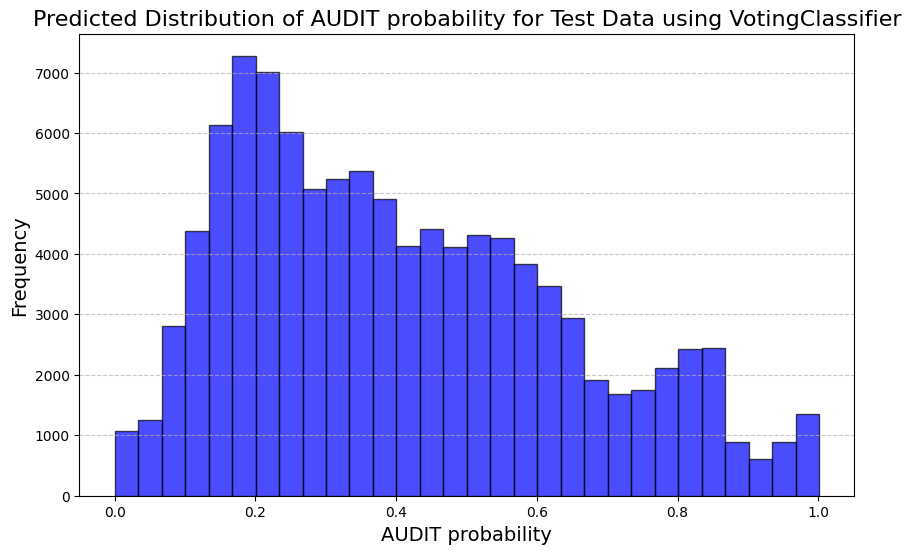

In [195]:
plt.figure(figsize=(10, 6))
plt.hist(data_test_predictions_ensemble['AUDIT_IND'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Predicted Distribution of AUDIT probability for Test Data using VotingClassifier', fontsize=16)
plt.xlabel('AUDIT probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Aggregation by FAC_NO

In [175]:
top_FACs = data_test_predictions_ensemble.groupby('FAC_NO').AUDIT_IND.mean().reset_index().sort_values('AUDIT_IND', ascending=False)
top_FACs['FAC_NAME'] = top_FACs.FAC_NO.map(FAC_NO_to_NAME_mapping)

top_10 = top_FACs.head(10)
top_10.AUDIT_IND = top_10.AUDIT_IND * 100

bottom_10 = top_FACs.tail(10)
bottom_10.AUDIT_IND = bottom_10.AUDIT_IND * 100

top_FACs

,FAC_NO,AUDIT_IND,FAC_NAME
80,106541123,0.983589,PORTERVILLE STATE HOSPITAL
60,106494019,0.845948,KAISER FOUNDATION HOSPITAL - SANTA ROSA
51,106484044,0.845336,KAISER FOUNDATION HOSPITAL - VACAVILLE
27,106431506,0.845040,KAISER FOUNDATION HOSPITAL - SAN JOSE
17,106414139,0.843384,KAISER FOUNDATION HOSPITAL - REDWOOD CITY
...,...,...,...
22,106430763,0.130090,EL CAMINO HOSPITAL
41,106450949,0.126457,MERCY MEDICAL CENTER - REDDING
56,106491064,0.109326,SANTA ROSA MEMORIAL HOSPITAL
29,106434040,0.082104,LUCILE SALTER PACKARD CHILDREN'S HOSPITAL AT STAN


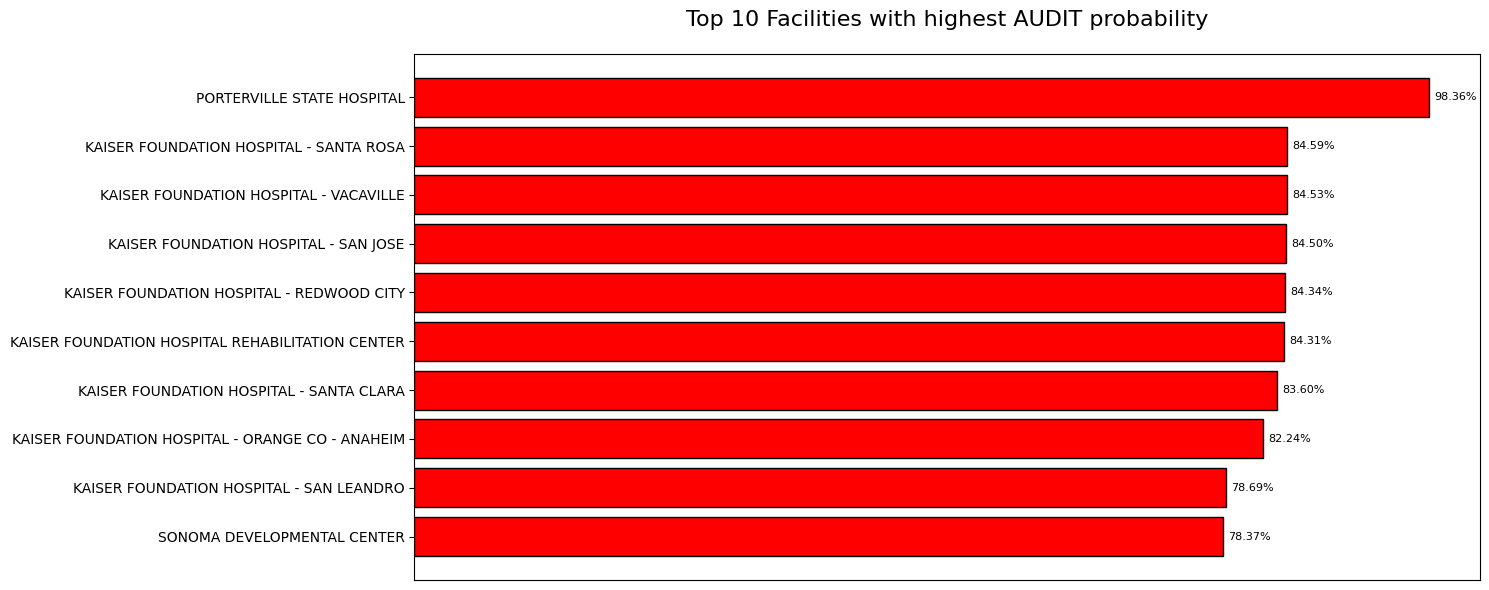

In [196]:
plt.figure(figsize=(15, 6))
bars = plt.barh(top_10['FAC_NAME'], top_10['AUDIT_IND'], color='red', edgecolor='black')

for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}%', va='center', fontsize=8)

plt.title('Top 10 Facilities with highest AUDIT probability', fontsize=16, pad=20)
plt.gca().invert_yaxis() 
plt.xticks([]) 
plt.tight_layout()
plt.show()

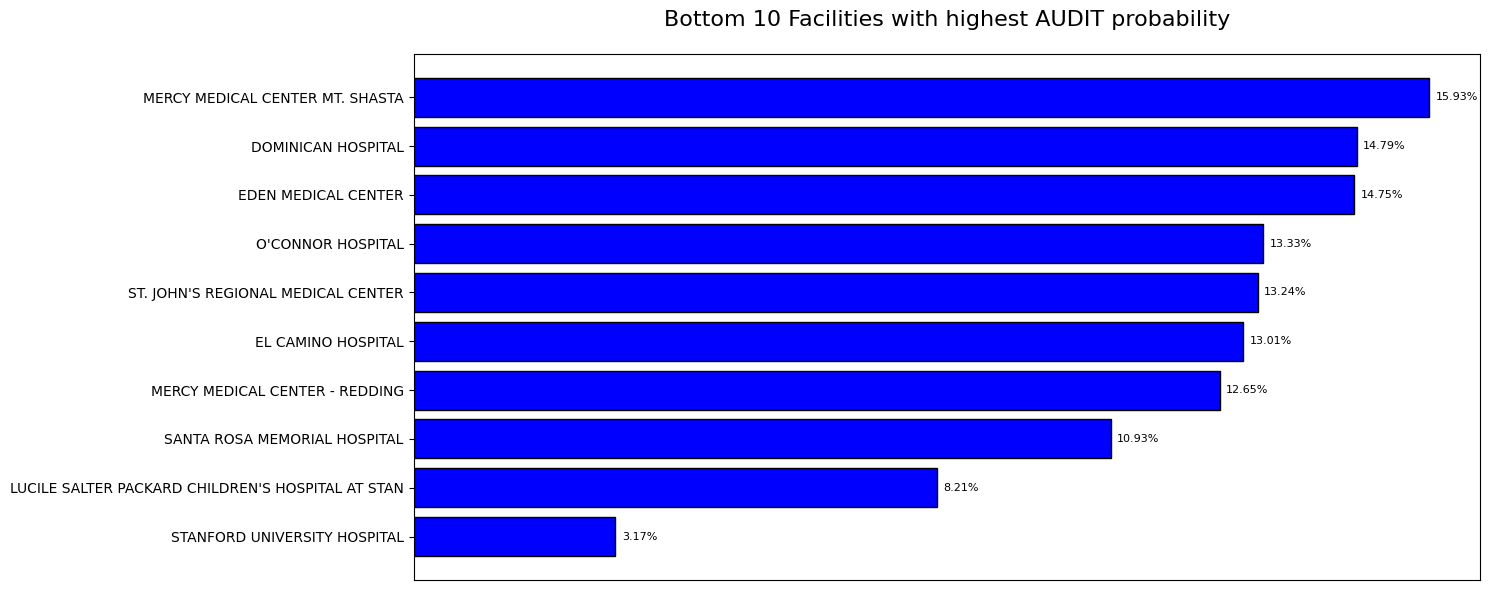

In [197]:
plt.figure(figsize=(15, 6))
bars = plt.barh(bottom_10['FAC_NAME'], bottom_10['AUDIT_IND'], color='blue', edgecolor='black')

for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}%', va='center', fontsize=8)

plt.title('Bottom 10 Facilities with highest AUDIT probability', fontsize=16, pad=20)
plt.gca().invert_yaxis() 
plt.xticks([]) 
plt.tight_layout()
plt.show()

Aggregation by FAC_NO and different Units

In [178]:
data_test_predictions_ensemble['Unit'] = data_test_predictions_ensemble['Variable'].map(reverse_lookup)
grouped = data_test_predictions_ensemble.groupby(['FAC_NO', 'Unit']).AUDIT_IND.mean().reset_index()

pivot_table = grouped.pivot(index='FAC_NO', columns='Unit', values='AUDIT_IND').reset_index()
pivot_table = pivot_table.sort_values(by='FAC_NO')

pivot_table

Unit,FAC_NO,Ambulatory and Referred Outpatient Visits,Balance Sheet Information,Capitation Premium Revenue,Contracted Labor Hours by Classification,Deductions from Revenue,Direct Expenses by Cost Center Group,Expenses by Natural Classification,Hospital Personnel Information,Inpatient Utilization by Payer,...,Net Patient Revenue by Payer,Nursery Information,Other Selected Utilization Information,Outpatient Visits by Payer,Patient Revenue Information,Productive Hours by Employee Classification,Selected Financial Items,Summary Income Statement,Total Paid Hours by Cost Center Group,Total Productive Hours by Cost Center Group
0,106014132,0.820531,0.716879,0.744616,0.766685,0.735662,0.721705,0.769779,0.826727,0.806834,...,0.737108,0.793045,0.807214,0.790165,0.750382,0.777831,0.752260,0.762836,0.770017,0.750168
1,106014233,0.144699,0.116380,0.197097,0.153665,0.152309,0.154566,0.132797,0.146564,0.150539,...,0.148542,0.174834,0.150884,0.153597,0.146069,0.141172,0.167381,0.149071,0.178857,0.179055
2,106014326,0.789377,0.685558,0.703657,0.711152,0.719448,0.689207,0.780075,0.803948,0.781353,...,0.728806,0.778228,0.776952,0.741126,0.738439,0.775234,0.709975,0.732973,0.744634,0.725289
3,106014337,0.828554,0.735345,0.757489,0.769826,0.758221,0.738296,0.784958,0.841808,0.827228,...,0.764972,0.794465,0.819906,0.795769,0.772638,0.791896,0.762548,0.769298,0.785929,0.765191
4,106105125,0.392565,0.316679,0.332277,0.325089,0.341328,0.355805,0.404636,0.391851,0.373833,...,0.338119,0.325610,0.349533,0.353435,0.353884,0.360355,0.335795,0.385343,0.351021,0.332874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,106560838,0.604340,0.538566,0.618835,0.620910,0.578227,0.606001,0.601805,0.589583,0.589738,...,0.567219,0.623951,0.599892,0.600364,0.572631,0.612385,0.609538,0.576304,0.610562,0.599458
91,106564121,0.616990,0.548436,0.614411,0.606488,0.580580,0.558454,0.512399,0.576267,0.611371,...,0.571948,0.635638,0.635480,0.597923,0.544452,0.563303,0.598707,0.556880,0.582422,0.576275
92,106571086,0.142002,0.157795,0.206060,0.165559,0.201342,0.205141,0.177070,0.125041,0.159503,...,0.194018,0.211551,0.174604,0.162012,0.180169,0.169369,0.221087,0.173296,0.155456,0.197898
93,106574010,0.311761,0.287721,0.381261,0.353574,0.329104,0.348292,0.319233,0.273144,0.320000,...,0.324537,0.338572,0.320047,0.332589,0.298373,0.331142,0.369123,0.308503,0.321793,0.362594


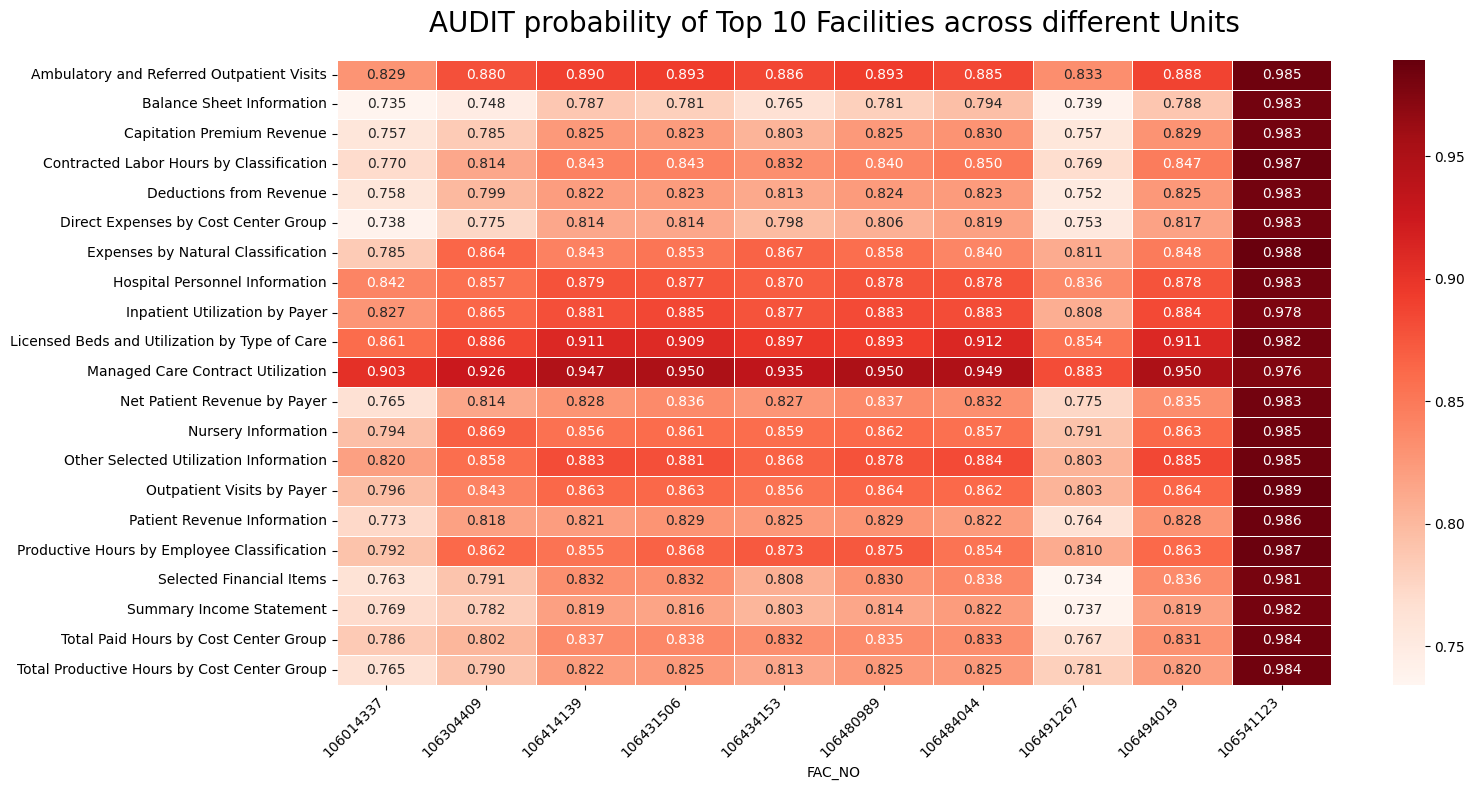

In [198]:
grouped_top_10 = grouped[grouped.FAC_NO.isin(top_10.FAC_NO.unique())]
grouped_top_10['FAC_NAME'] = grouped_top_10.FAC_NO.map(FAC_NO_to_NAME_mapping)

heatmap_data = grouped_top_10.pivot(index='Unit', columns='FAC_NO', values='AUDIT_IND')

plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="Reds", linewidths=0.5)
plt.title('AUDIT probability of Top 10 Facilities across different Units', fontsize=20, pad=20)
plt.xticks(rotation=45, ha='right')
plt.xlabel('FAC_NO')
plt.ylabel('')
plt.tight_layout()
plt.show()

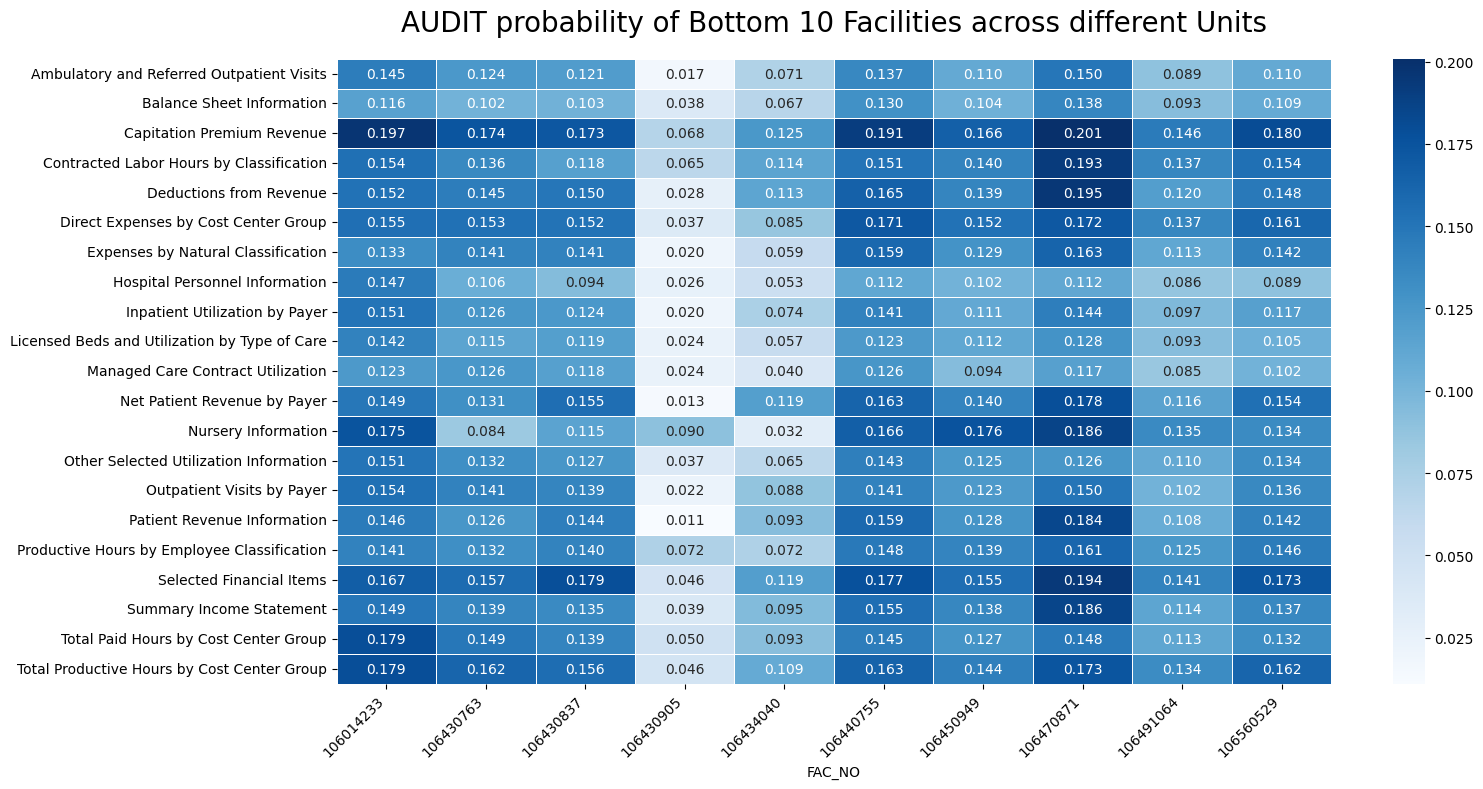

In [199]:
grouped_bottom_10 = grouped[grouped.FAC_NO.isin(bottom_10.FAC_NO.unique())]
grouped_bottom_10['FAC_NAME'] = grouped_bottom_10.FAC_NO.map(FAC_NO_to_NAME_mapping)

heatmap_data = grouped_bottom_10.pivot(index='Unit', columns='FAC_NO', values='AUDIT_IND')

plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="Blues", linewidths=0.5)
plt.title('AUDIT probability of Bottom 10 Facilities across different Units', fontsize=20, pad=20)
plt.xticks(rotation=45, ha='right')
plt.xlabel('FAC_NO')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Evaluation for actual vs predicted data test 

In [209]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support

predictions = data_test_predictions_XG.AUDIT_IND.values
true_labels = data_test.AUDIT_IND.values

predicted_labels = (predictions > 0.5).astype(int)

roc_auc = roc_auc_score(true_labels, predictions)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

print('Classifier: XGB')
print('\nAUC:', roc_auc)
print('\nConfusion Matrix:')
print('\n',conf_matrix)
print('\nPrecision:', precision)
print('\nRecall:', recall)
print('\nF1:', f1)

Classifier: XGB

AUC: 0.7964048615459548

Confusion Matrix:

 [[45589 15256]
 [14953 28262]]

Precision: 0.649432418769245

Recall: 0.6539858845308342

F1: 0.6517011979292772


# Results

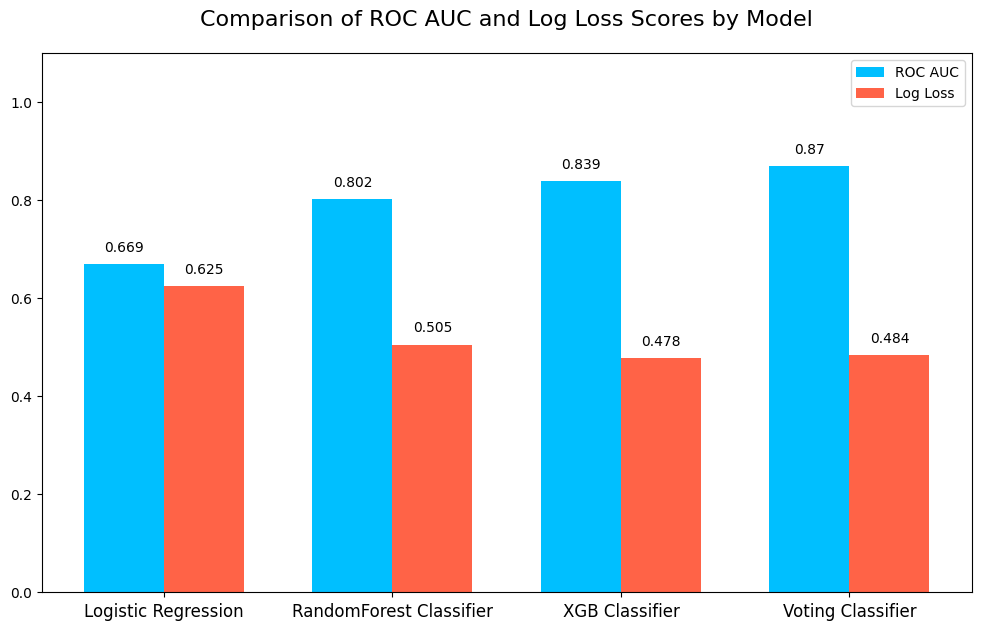

In [193]:
models = ['Logistic Regression', 'RandomForest Classifier', 'XGB Classifier', 'Voting Classifier']

roc_auc_values = [evaluation_results_LR['ROC AUC (Mean)'].mean(), evaluation_results_RF['ROC AUC (Mean)'].mean(), 
                  evaluation_results_XG['ROC AUC (Mean)'].mean(), evaluation_results_ensemble['ROC AUC (Mean)'].mean()]
log_loss_values = [evaluation_results_LR['Log Loss (Mean)'].mean(), evaluation_results_RF['Log Loss (Mean)'].mean(), 
                  evaluation_results_XG['Log Loss (Mean)'].mean(), evaluation_results_ensemble['Log Loss (Mean)'].mean()]

fig, ax = plt.subplots(figsize=(12, 7))
width = 0.35   
ind = np.arange(len(models))

roc_auc_bars = ax.bar(ind - width/2, roc_auc_values, width, label='ROC AUC', color='deepskyblue')
log_loss_bars = ax.bar(ind + width/2, log_loss_values, width, label='Log Loss', color='tomato')

for bar in roc_auc_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 3), ha='center', va='bottom')

for bar in log_loss_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 3), ha='center', va='bottom')

ax.set_title('Comparison of ROC AUC and Log Loss Scores by Model', fontsize=16, pad=20)
ax.set_xticks(ind)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylim(0, 1.1)
ax.legend()

plt.show()